# Recurrent Neural Network Using Historical Data

I experimented with this, forking code from other places. The concept was rather than using a regression model, it may be a good strategy to classify outocomes based on previous results. The inspiration comes from [This RNN ](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/sequences/text_generation.ipynb?fbclid=IwAR3GjuB85ikuBM89WGpJLLxykHZBZ3LR2Pk5PUi6jTI9Q0IoW8z50ShgRf4#scrollTo=ktovv0RFhrkn) trained on shakespeare. I figured it was a good way to get my feet wet using tensorflow and do my own project. 

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import os
from google.colab import files
import time

## make_set formula:
Assuming the input is an array a of length greater than 1, we need to get the percent change on each day. then
$$p_i =  \frac{a_i -a_{i-1}}{a_{i-1}}*1000$$
where p is a percent change array. We round the result for consisten classification.
## recover formula:
Needing an official input, recovery must be done iteratively, but all we have are the percents. Assuming we have $a_0$ and all $p_i$'s, the first item is the following:
$$a_1 = \frac{a_0*p_1 }{1000} + a_0$$
which iteratively follows:

$$a_i = \frac{a_{i-1}*p_i }{1000} + a_{i-1}$$

In [0]:
# note this set must contain ALL the data's discrete derivative points. 
# otherwise classification and training 
def make_set(df):
    length = len(df)
    new_vec = []
    for i in range(length - 1):
        new_Val = (df[i + 1] - df[i])/df[i]
        new_Val = round(new_Val * 1000)
        # assume a 90% drop is rare enough to ignore
        if new_Val < -900:
          new_Val = -900
        # assume a 100% gain is rare enough to ignore (outliers)
        if new_Val > 1000:
          new_Val = 1000
        # now at most a len 1900 vector to train on, largest I have seen is 500
        new_vec.append(int(new_Val))
    return np.array(new_vec)


# get values from old set, initial needs to be the number BEFORE the percents list
def recover(initial, percents):
    recoverd_vals = [initial]
    for i in percents:
        initial += initial * i / 1000
        recoverd_vals.append(initial)
    return np.array(recoverd_vals)
  
def build_model(size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    rnn(rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(size)
  ])
  return model

# Wrapping the Data in a Class

Datasets takes in names of pandas stored files, sorted on date. Ensure Open is part of the header, it only uses that column

In [0]:
class Datasets:
    percents = set()
    full_sets = []
    original_values = []
    vectord_stocks = []
    names = []
    moves = None
    steps_per_epoch = []
    datasets = []
    price_to_index = {}
    index_to_price = np.array([])

    # HyperParams
    BATCH_SIZE = 16
    sequence_length = 50
    BUFFER_SIZE = 100000
    EPOCHS = 1

    def __init__(self, paths):
        self.paths = paths
        for i in paths:
            self.make_sets(i)
        self.vectorize_stocks()
        self.make_datasets()

    def make_datasets(self):
        def split_input_target(chunk):
            input_price = chunk[:-1]
            target_price = chunk[1:]
            return input_price, target_price

        for stock in self.vectord_stocks:
            dataset = tf.data.Dataset.from_tensor_slices(stock)
            dataset = dataset.batch(self.sequence_length + 1, drop_remainder=True).map(split_input_target)
            self.datasets.append(dataset.shuffle(self.BUFFER_SIZE).batch(self.BATCH_SIZE, drop_remainder=True))

    def vectorize_stocks(self):
        moves = sorted(self.percents)
        self.moves = moves
        self.price_to_index = {u: i for i, u in enumerate(moves)}
        self.index_to_price = np.array(moves)
        for stock in self.full_sets:
            self.vectord_stocks.append(np.array([self.price_to_index[c[0]] for c in stock]))
            step_size = len(stock) // self.sequence_length
            self.steps_per_epoch.append(step_size // self.BATCH_SIZE)

    def make_sets(self, path):
        df = pd.read_csv(path)
        self.names.append(path[:len(path) - 4])
        df = df['Open'].values
        self.original_values.append(df)
        full_set = make_set(df)
        Datasets.percents = Datasets.percents.union(full_set)

        # dont train on last 50 points of data for testing purposes
        length = len(full_set) - 50
        self.full_sets.append(full_set[:length].reshape(-1, 1))

    def get_initial_val(self, set_idx, points_back):
        temp = self.original_values[set_idx]
        return temp[len(temp) - 51 - points_back]

    def get_test_vals(self, set_idx, points_back):
        temp = self.full_sets[set_idx].reshape(1, -1)[0]
        return temp[len(temp) - points_back:]

    def get_true_vals(self, set_idx, points_back):
        temp = self.original_values[set_idx]
        return temp[len(temp) - 51 - points_back:]

    def get_batch_size(self):
        return self.BATCH_SIZE

    def get_buffer_size(self):
        return self.BUFFER_SIZE

    def get_moves(self):
        return self.percents

    def get_sequence_len(self):
        return self.sequence_length

    def __len__(self):
        return len(self.names)

    def get_data(self, idx):
        return self.datasets[idx]

    def get_steps(self, idx):
        return self.steps_per_epoch[idx]

    def get_EPOCHS(self):
        return self.EPOCHS

    def get_name(self, idx):
        return self.names[idx]

    def price_to_idx(self, key):
        return  self.price_to_index[key]

    def idx_to_price(self):
        return self.index_to_price



In [5]:
df = pd.read_csv('GE.txt')
dx = pd.read_csv('BAC.txt')
df = df['Open'].values
dx = dx['Open'].values
full_set1 = make_set(df)
full_set2 = make_set(dx)
moves = sorted(set(full_set1).union(full_set2))
full_set1 = full_set1.reshape(-1, 1)
full_set2 = full_set2.reshape(-1, 1)
import glob, os
os.chdir(".")
stonks = []

for file in glob.glob("*.txt"):
    #print(str(file))
    stonks.append(file)


data = Datasets(stonks)
len(data.get_moves())

331

# Testing recover error
The graph below sees how far off the price gets when it is recovered.  The visual shows it does pretty well.

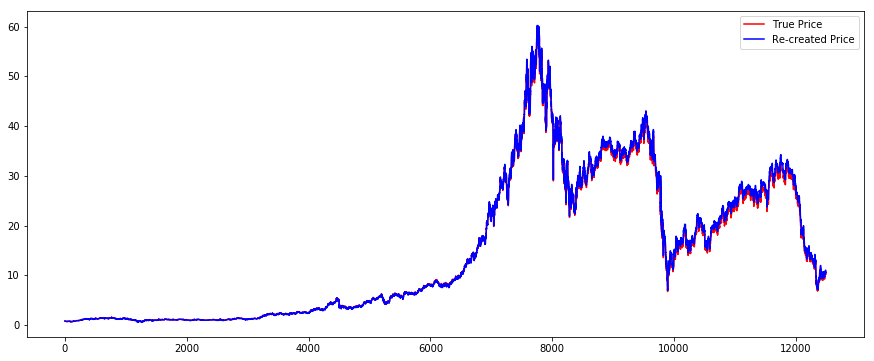

In [6]:
y = df[:]
p = recover(y[0], full_set1.reshape(1, -1)[0])
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(y, color='red', label='True Price')
plt.plot(p, color='blue', label='Re-created Price')
plt.legend()

In [0]:
# uniqe price movments to classify
size = len(data.get_moves())

# The embedding dimension
embedding_dim = 256 * 3

# Number of RNN units
rnn_units = 1024 


In [9]:
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

model = build_model(
  size = len(data.get_moves()),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=data.get_batch_size())

# Loss function is a type of probablity distribution
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(
    optimizer = tf.train.AdamOptimizer(),
    loss = loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, None, 768)           254208    
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (16, None, 1024)          5511168   
_________________________________________________________________
dense (Dense)                (16, None, 331)           339275    
Total params: 6,104,651
Trainable params: 6,104,651
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)
EPOCHS = 100
for j in range(0):
  print("Epoch {}:".format(j+1))
  for i in range(len(data)):
    if i == 0 and j == 0:
      for _ in range(1):
        history = model.fit(data.get_data(i).repeat(), epochs=data.get_EPOCHS(), steps_per_epoch=data.get_steps(i), callbacks=[checkpoint_callback])
      continue
    history = model.fit(data.get_data(i).repeat(), epochs=data.get_EPOCHS(), steps_per_epoch=data.get_steps(i), callbacks=[checkpoint_callback])
    

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)
# !zip -r file.zip ./training_checkpoints
#files.download('file.zip') 

model = build_model(size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [98]:

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (1, None, 768)            248064    
_________________________________________________________________
cu_dnngru_15 (CuDNNGRU)      (1, None, 1024)           5511168   
_________________________________________________________________
dense_15 (Dense)             (1, None, 323)            331075    
Total params: 6,090,307
Trainable params: 6,090,307
Non-trainable params: 0
_________________________________________________________________


In [0]:
def generate_prices(model, start_vals):
  """
  model: the input RNN
  start_vals: Initial values to pedict with
  """
  # Number of future prices to predict, consider it a hyperparameter
  num_generate = 50
  
  # Converting prices to next
  input_eval = [data.price_to_index[s] for s in start_vals]
  input_eval = tf.expand_dims(input_eval, 0)

  # Start return list with the inital prices
  prices = [i for i in start_vals]

  # Another hyper param, lowering reduces randomness to the model
  variance = .0002
  index_to_price = data.idx_to_price()

  
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # disributions
      predictions = predictions / variance
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

      # moving forward one with the model one at a time
      input_eval = tf.expand_dims([predicted_id], 0)
      prices.append(index_to_price[predicted_id])

  return prices

# Comparing with Test Set

Shown here is the results. Since the days go out 50 in the generate_prices function, the last 50 days of the set is a visual of performance. Note, the days it guessed were NOT used in the training set. You can verify this by observing the datasets class, and recompliling the notebook. A good metric would be needed to asses for validation, this is only a visual representation.  From a quick glance it looks like it performs fairly well, considering the objective function is cross entropy. This means the model produced the most likely outcome without any new data imputs. I also noticed days_to_test_on is another hyper-parameter. I am actually suprized error did not accumulate and only a few got away from themselves.

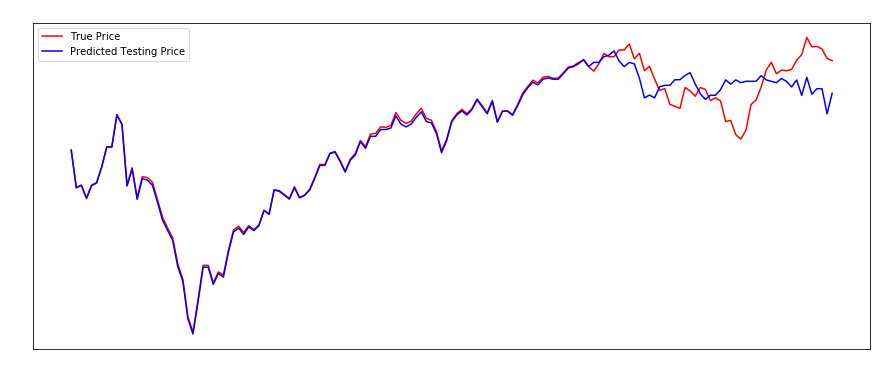

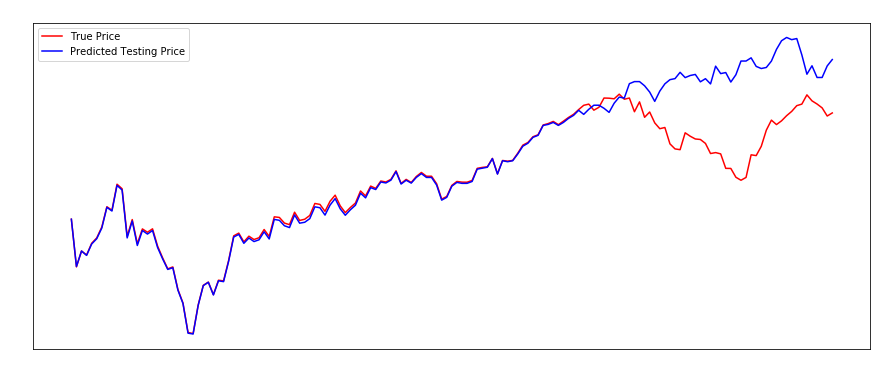

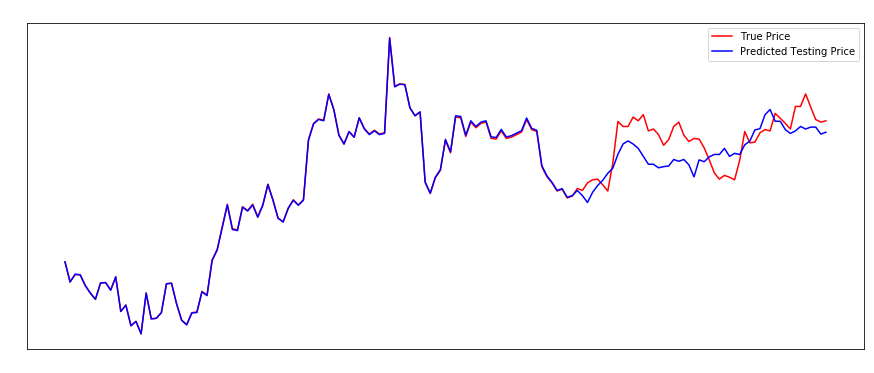

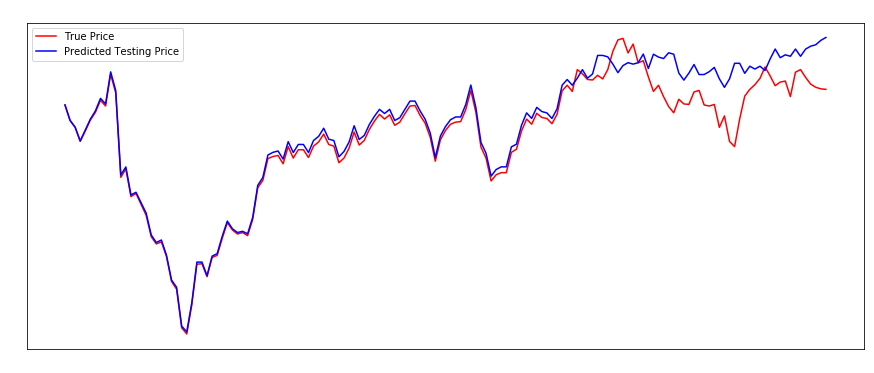

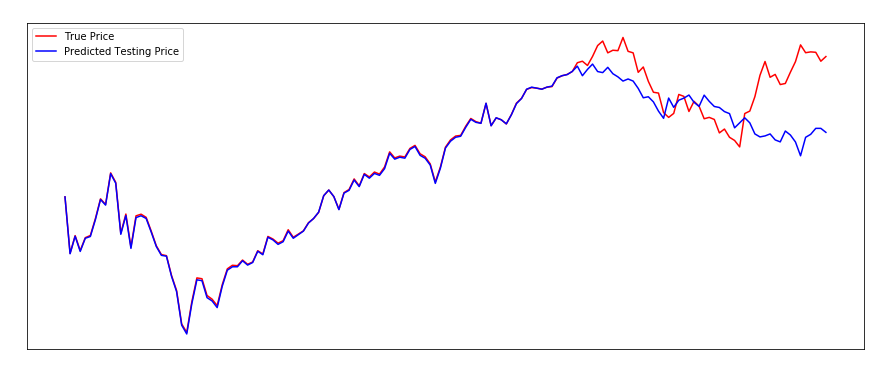

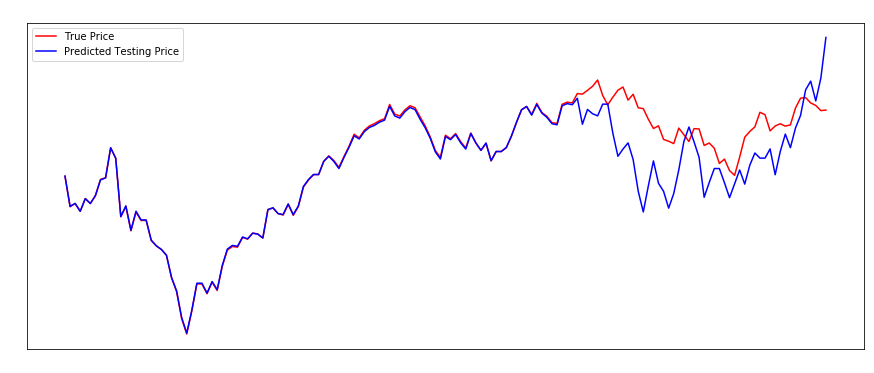

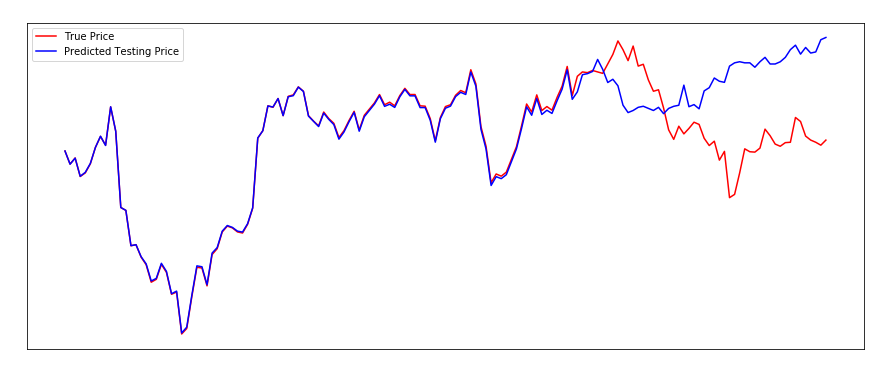

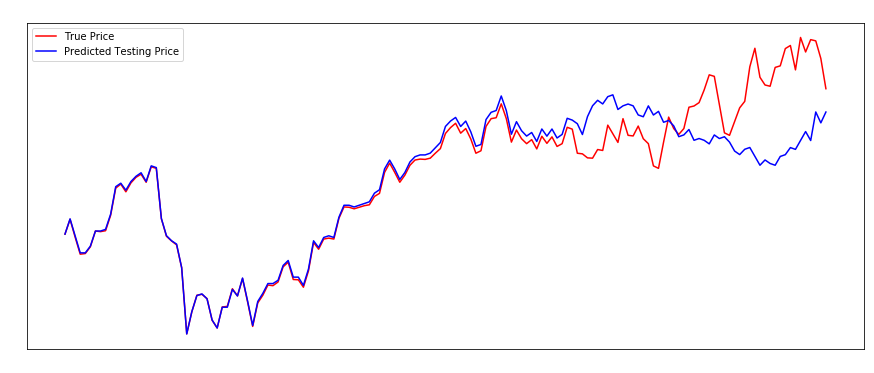

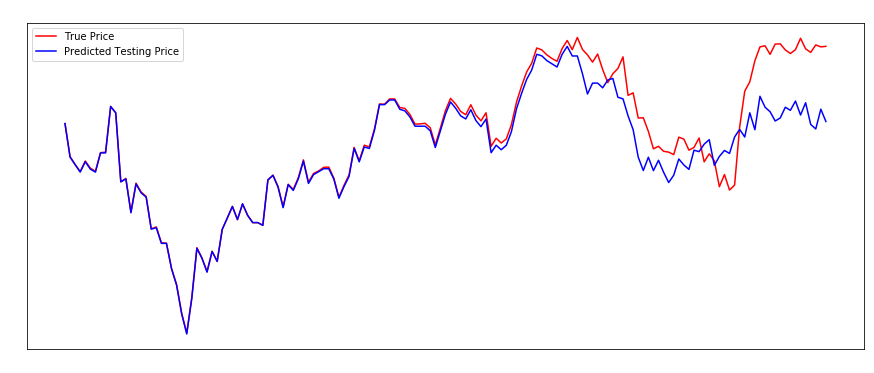

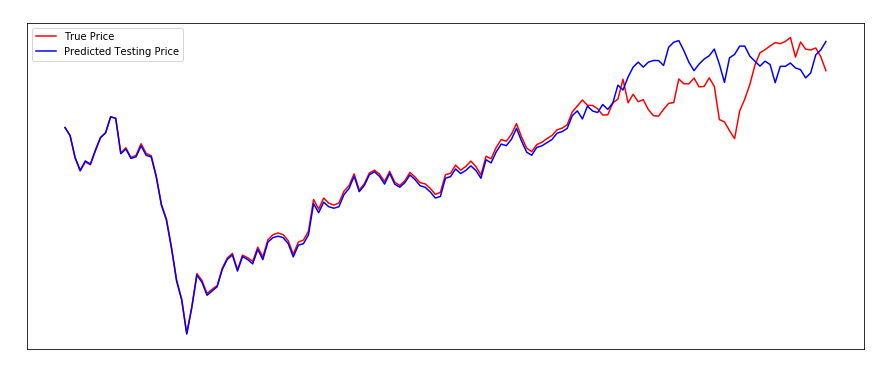

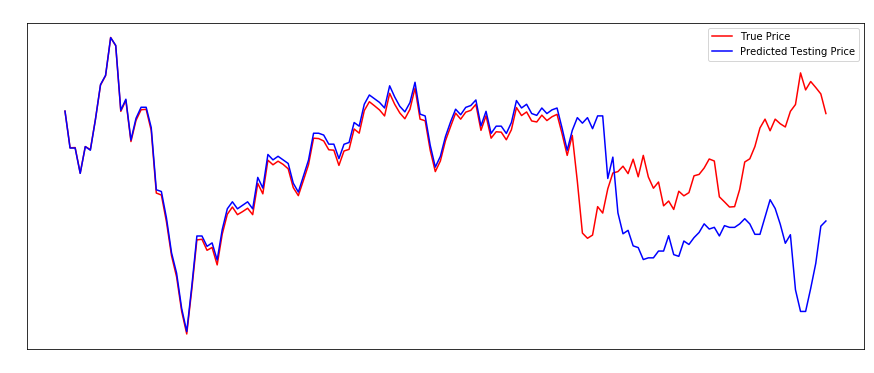

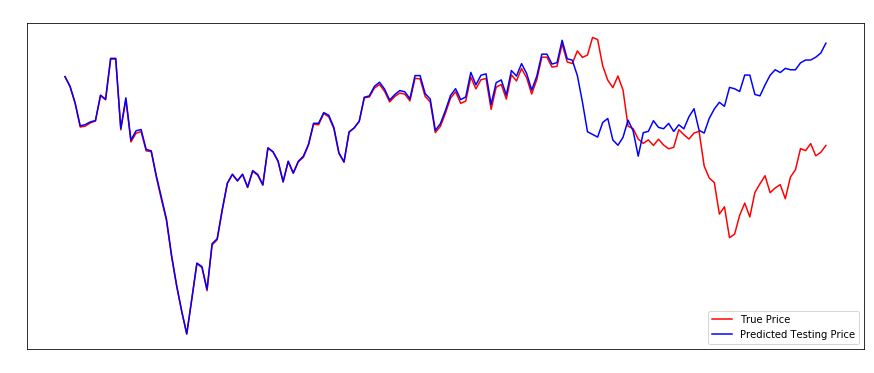

In [112]:

for i in range(len(data)):
  days_to_test_on = 100
  x = generate_prices(model, data.get_test_vals(i, days_to_test_on))

  p = recover(data.get_initial_val(i, days_to_test_on), x)

  fig, ax = plt.subplots(figsize=(15,6))
  ax.set_title('{}'.format(data.get_name(i)), color='white')
  ax.plot(data.get_true_vals(i, days_to_test_on)[:], color='red', label='True Price')
  ax.tick_params(axis='x', colors='white')
  ax.tick_params(axis='y', colors='white')
  plt.plot(p[:], color='blue', label='Predicted Testing Price')
  plt.legend()
